In [4]:
import time
import numpy as np
import re
import pandas as pd
from collections import OrderedDict
from datetime import datetime as dt, timedelta
import pytz

#Model libraries
!pip install prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
# from IPython.display import display

#Evaluation & HP Tuning
!pip install optuna 
import optuna  # pip install optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [148]:
#Read in dataset
df = pd.read_csv('../final_data.csv')
df['date_reported'] = pd.to_datetime(df['date_reported'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['ZIP_Code'] = df['ZIP_Code'].astype('int').astype('str')

# Hyperparameter Tune

In [185]:
#Function to train test split
def evaluate_data(df, zip_code):
    df_prophet = df.copy().rename(columns={"incident_date":"ds"})
    df_prophet.set_index("ds", inplace=True)

    monthly_crime_counts = df_prophet.groupby('ZIP_Code').resample('M').size()
    monthly_crime_counts = monthly_crime_counts.rename('y').reset_index()
    model_df = monthly_crime_counts[monthly_crime_counts['ZIP_Code'] == zip_code]

    t_index = round(len(model_df)*0.7)

    train = model_df[:t_index]
    val = model_df[t_index:-int((len(model_df) - t_index)/2)]
    test = model_df[-len(val)+1:]

    return train, val, test

#Call function for zip code 22201
train, val, test = evaluate_data(df, '22201')

In [186]:
#Define optuna function with search grid
def objective(trial, train, val):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        #'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 5, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20)
    }
    
    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.fit(train)
    preds = m.predict(val[['ds']])
    
    #mae_score = mean_absolute_error(val['y'], preds['yhat'])
    mape = mean_absolute_percentage_error(val['y'], preds['yhat'])
    
    return mape

In [187]:
#Create study and run trials
study = optuna.create_study(direction="minimize", study_name="FBProphet - Zip 22201 Crime")
func = lambda trial: objective(trial, train, val)
study.optimize(func, n_trials=1500)

[I 2024-04-16 00:47:25,702] A new study created in memory with name: FBProphet - Zip 22201 Crime


00:47:25 - cmdstanpy - INFO - Chain [1] start processing
00:47:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-04-16 00:47:27,368] Trial 0 finished with value: 0.21261576392511533 and parameters: {'changepoint_prior_scale': 0.987468780305044, 'changepoint_range': 0.8573445653983358, 'seasonality_prior_scale': 3.4564555673942943, 'holidays_prior_scale': 7.793932730173921, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': 7, 'yearly_seasonality': 18}. Best is trial 0 with value: 0.21261576392511533.
00:47:27 - cmdstanpy - INFO - Chain [1] start processing
00:47:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-04-16 00:47:28,181] Trial 1 finished with value: 0.2198578575248111 and parameters: {'changepoint_prior_scale': 3.5443900747244235, 'changepoint_range': 0.8002244527480229, 'seasonality_prior_scale': 7.6147976486851086, 'holidays_prior_scale': 1.8801287738078332, 'seasonality_mode': 'additive', 'weekly_seasonality': 10, 'yearly_seasonality': 9}. Best is 

C:\Users\Andrew\AppData\Local\Temp\ipykernel_20592\3324289224.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

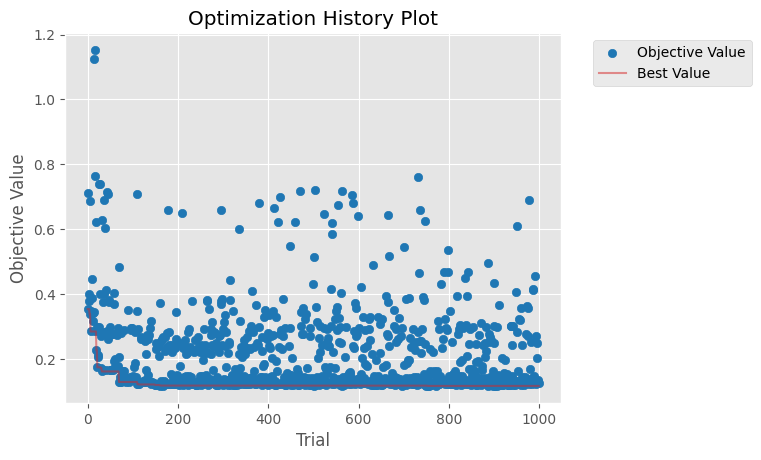

In [158]:
plot_optimization_history(study)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_20592\3836449081.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

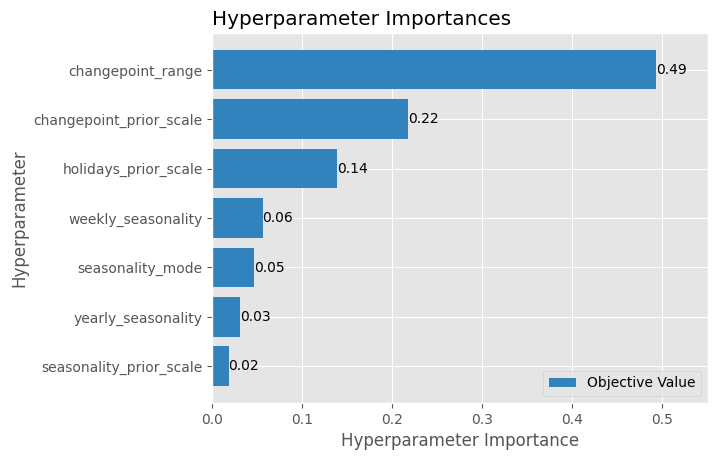

In [131]:
plot_param_importances(study)

In [132]:
#Best params using MAPE
print(study.best_value)
study.best_params

0.10254724827708644


{'changepoint_prior_scale': 2.0572436973839325,
 'changepoint_range': 0.8372595709743088,
 'seasonality_prior_scale': 3.0669614906164115,
 'holidays_prior_scale': 5.944894747597239,
 'seasonality_mode': 'multiplicative',
 'weekly_seasonality': 7,
 'yearly_seasonality': 4}

In [179]:
#Test
best_params = study.best_params

concat_df = pd.concat([train, val])

m = Prophet(**best_params)
m.add_country_holidays(country_name='US')
m.fit(concat_df)
preds = m.predict(test[['ds']])
    
mean_absolute_percentage_error(test['y'], preds['yhat'])

22:05:43 - cmdstanpy - INFO - Chain [1] start processing
22:05:43 - cmdstanpy - INFO - Chain [1] done processing


0.24673230354087664

# Forecast

In [174]:

#def prophet_forecast(df, autoregressive_weight, zip_code, crime, periods:int):

def prophet_forecast(df, params, zip_code, crime, periods:int):
    """ 
    This function uses Facebook's Prophet time series forecasting algorithm to
    predict the number of crimes that will be committed in a given zip code.
    
    Inputs:
    - df: DataFrame containing crime data, with columns 'date_reported' (datetime), 'zip' (str), and any additional columns.
    - autoregressive_weight: Numeric value representing the changepoint prior scale for Prophet. Higher values make the forecast more flexible.
    - zip_code: String representing the zip code for which the forecast will be made.
    
    Returns:
    - fig_forecast: Plotly figure object displaying the forecast.
    - fig_components: Plotly figure object displaying the forecast components.
    """
    # Initialize Prophet model
    # m = Prophet(changepoint_prior_scale=autoregressive_weight)
    m = Prophet(**params)
    
    # Prepare the DataFrame for Prophet
    #df_prophet = df.copy().rename(columns={"date_reported":"ds"})
    df_prophet = df.copy().rename(columns={"incident_date":"ds"})
    df_prophet.set_index("ds", inplace=True)
    if crime == 'all':
        df_prophet = df_prophet
    else:
        df_prophet = df_prophet[df_prophet['CategoryCode']==crime]

    monthly_crime_counts = df_prophet.groupby('ZIP_Code').resample('M').size()
    monthly_crime_counts = monthly_crime_counts.rename('y').reset_index()
    model_df = monthly_crime_counts[monthly_crime_counts['ZIP_Code'] == zip_code]
    
    # Fit the model
    m.fit(model_df)
    
    # Make future dataframe
    future = m.make_future_dataframe(periods=periods, freq='M')
    
    # Make predictions
    forecast = m.predict(future)
    
    # Plot forecast and components
    fig_forecast = plot_plotly(m, forecast)
    fig_components = plot_components_plotly(m, forecast)
    
    return fig_forecast, fig_components

In [184]:
#Check top zip code with most data to monitor final forecasting performance
df_prophet = df.copy().rename(columns={"incident_date":"ds"})
df_prophet.set_index("ds", inplace=True)
grouped = df_prophet.groupby('ZIP_Code').resample('M').size()
grouped.rename('y').reset_index().groupby(['ZIP_Code']).sum()['y'].reset_index().sort_values(['y'], ascending=False).head(4)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_20592\1209805566.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,ZIP_Code,y
10,22202,8957
12,22204,6729
9,22201,6713
11,22203,4969


In [177]:
#Forecast zip code 22201
fig_forecast, fig_components = prophet_forecast(df, 
                                                # autoregressive_weight=0.5, 
                                                best_params,
                                                zip_code='22201',
                                                crime=2,
                                                periods=12)

# Display the forecast plot
# display(fig_forecast)
fig_forecast

# Display the forecast components plot
# display(fig_components)
fig_components

22:04:59 - cmdstanpy - INFO - Chain [1] start processing
22:04:59 - cmdstanpy - INFO - Chain [1] done processing


In [182]:
#Forecast 22202
fig_forecast, fig_components = prophet_forecast(df, 
                                                # autoregressive_weight=0.5, 
                                                best_params,
                                                zip_code='22202',
                                                crime=2,
                                                periods=12)

# Display the forecast plot
# display(fig_forecast)
fig_forecast

# Display the forecast components plot
# display(fig_components)
fig_components

22:07:29 - cmdstanpy - INFO - Chain [1] start processing
22:07:29 - cmdstanpy - INFO - Chain [1] done processing


In [183]:
#Forecast 22204
fig_forecast, fig_components = prophet_forecast(df, 
                                                # autoregressive_weight=0.5, 
                                                best_params,
                                                zip_code='22204',
                                                crime=2,
                                                periods=12)

# Display the forecast plot
# display(fig_forecast)
fig_forecast

# Display the forecast components plot
# display(fig_components)
fig_components

22:07:42 - cmdstanpy - INFO - Chain [1] start processing
22:07:42 - cmdstanpy - INFO - Chain [1] done processing
